### Student ID: 18195067
### Student Name: Abhijit Sinha

# E-tivity 3: Clustering and Manifold Learning

**Use this notebook to complete Tasks 1 and 2 in E-tivity3.**

### Import Python Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold
from sklearn import cluster
from sklearn import preprocessing

In [2]:
# Using a global random seed for reproducible results when doing multiple runs
np.random.seed(42)

In [3]:
# Load the dataset into pandas dataframe
df = pd.read_csv("loans_dataset_et3.csv")

In [4]:
# Look at the first 5 data samples
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,2483,2466.0,90,180,0
1,4917,0.0,130,360,0
2,4106,0.0,40,180,1
3,3859,3300.0,142,180,1
4,6417,0.0,157,180,1


In [5]:
# Descriptive statistics of the data 
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,332.000000,332.000000,332.000000,332.000000,332.000000
mean,5201.093373,1495.508795,140.882530,341.710843,0.978916
std,4584.815491,1982.742932,75.544237,61.651497,0.143882
min,645.000000,0.000000,17.000000,60.000000,0.000000
25%,2912.750000,0.000000,100.000000,360.000000,1.000000
50%,3858.500000,1211.500000,128.000000,360.000000,1.000000
75%,5818.250000,2250.000000,162.000000,360.000000,1.000000
max,39999.000000,20000.000000,600.000000,480.000000,1.000000


### Observation:
There are no missing values in the dataset. The data contains 332 examples and 5 features/attributes

The dataset features have different scales with a `ApplicantIncome` and `CoapplicantIncome` being of larger order of magnitude compared to `LoanAmount` and `Loan_Amount_Term`. `Credit_History` seems to be a categorical attribute with binary outcome.

**Decision: Scaling is necessary for this dataset before applying clustering algorithm**

In [6]:
df.shape

(332, 5)

# Task 1 (CS5062)
*Cluster loans_dataset_et3.csv with the k-Means clustering algorithm and visualise the clustering. Use an appropriate feature-scaling technique and pick a value of k suggested by MDS and t-SNE visualisations of the dataset.* 

*Experiment with various values of the parameters of k-Means. **Aim at producing a meaningful clustering** that allows you to describe the clusters with words. Write a short conclusion about the characteristics of the clusters (max 250 words).*

### Tests:
1. Use an appropriate feature-scaling technique
2. pick a value of k suggested by MDS and t-SNE visualisations of the dataset.
3. Experiment with various values of the parameters of k-Means
4. Aim at producing a meaningful clustering that allows you to describe the clusters with words.

Reference: https://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html

In [7]:
X = np.array(df.values, dtype=float)

In [8]:
X.shape

(332, 5)

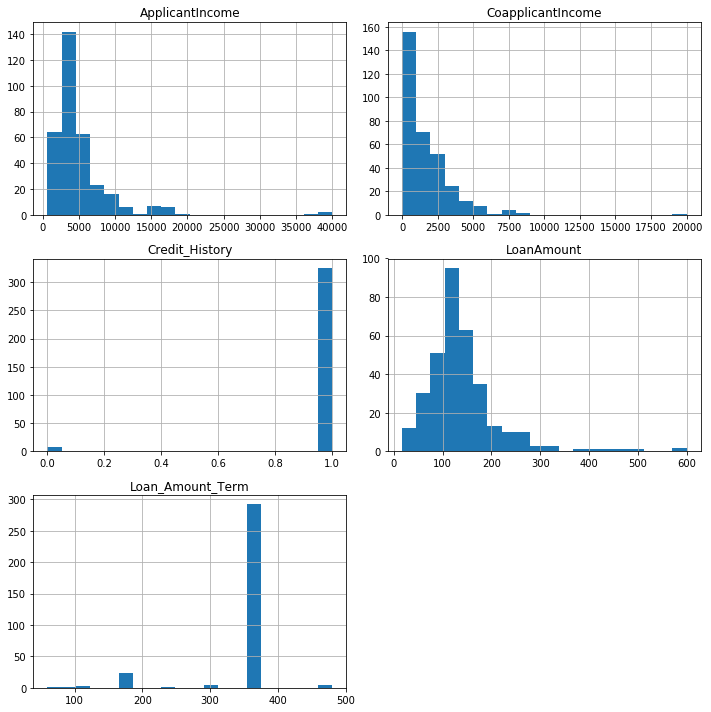

In [9]:
# Check the distribution of loan dataset
df.hist(figsize=(10,10), bins=20)
plt.tight_layout()
plt.show()

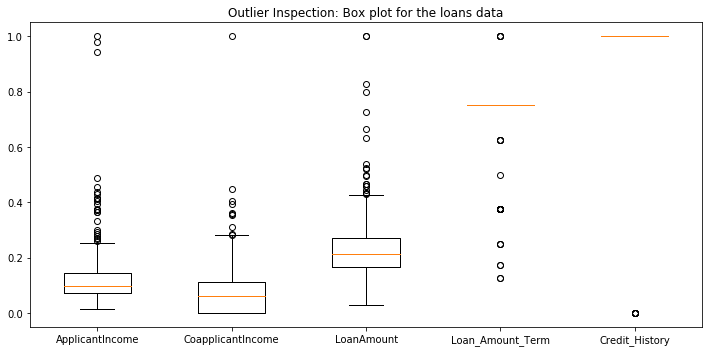

In [10]:
# Check if there are any outlier as it may affect the scaling algorithm
plt.figure(figsize=(10,5))
plt.boxplot([df[i]/df[i].max() for i in df.keys()], labels=df.keys())
plt.title('Outlier Inspection: Box plot for the loans data')
plt.tight_layout()
plt.show()

### Observation on the Distribution and Box Plots:
From the boxplot we can see that **there are some potential outliers in the dataset and this can affect the scaling outcome** and **Proper scaling technique needs to be used to counter the outliers so that we can get a good clustering outcome.**

## Scaling the data:

Scaling should be applied when there are input features on a different order of magnitude, or even large differences in the same order of magnitude, than other features. 
We need to take into account outliers and their effects on scaling. If the data contains many outliers(as in this case), scaling using the mean and variance of the data is likely to not work very well.

Performed a study on the various approaches to do scaling in scikit-learn:
- **StandardScaler**: Removes the mean and scales the data to unit variance
- **MinMaxScaler**: Rescales the data set such that all feature values are in the range [0, 1] 
- **MaxAbsScaler**: The absolute values are mapped in the range [0, 1], same as MinMaxScaler if we have only +ve data
- **RobustScaler**: The centering and scaling statistics of this scaler are based on percentiles and are therefore not influenced by a few number of very large marginal outliers
- **PowerTransformer**: applies a power transformation to each feature to make the data more Gaussian-like
- **QuantileTransformer**: (Gaussian: saturates outliers & uniform: same as robust scaler) -  it smooths out unusual distributions and is less influenced by outliers than scaling methods.


#### Decision on scaling: I have decide to use the QuantileTransformer with uniform scaling

##### Note: StandardScaler, MinMaxScaler and MeanAbsScaler is very sensitive to the presence of outliers and hence should not be used here.
References: 
- https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
- https://scikit-learn.org/stable/modules/preprocessing.html

In [11]:
# Scale the data with appropriate scaler which can handle ouliers
quantile_scaler = preprocessing.QuantileTransformer(output_distribution='uniform')
quantile_uniform_data = quantile_scaler.fit_transform(X)

In [12]:
# Reusing the plotting method from Lab 3 notebook
# Create an array of colors to distinguish the clusters during plotting
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple', 
                   'maroon', 'aqua', 'black', 'yellow', 'gray', 'magenta', 'cyan'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot
def clustering_scatterplot(points, labels, centers, title):
    # plot the examples, i.e. the data points
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=400)

    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')

## Manifold techniques used for K-Means:

### MDS:

The purpose of the MDS is to find a low-dimensional representation of the data (here 2D) in which the distances respect well the distances in the original high-dimensional space, unlike other manifold-learning algorithms, it does not seeks an isotropic representation of the data in the low-dimensional space.

Reference: https://scikit-learn.org/stable/modules/manifold.html

### T-SNE (T-distributed Stochastic Neighbor Embedding):
T-SNE tries to map high-dimensional into low-dimensional objects by preserving the neighbourhood relationship structure in spite of a trade-off consisting of a misclassification around the far objects. Drawback of T-SNE is that its computationally very expensive and 10 times slower than MDS

T-SNE Parameters:

- n_components: default (equal to 2), it is the number of the ending dimensions.
- Perplexity: It is the main parameter. The higher perplexity, the more the the number of neighbours. A good rule is setting it up between 5-50. 
    - If Perplexity is too small we will not capture enough neighbours; on the contrary, an excessive number will approach values too far.
- learning_rate: A range between 10 and 1000 is usually recommended

References: 
1. https://www.deeplearningitalia.com/stochastic-neighbor-embedding-sne-its-correction-in-t-sne/
2. https://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html

In [13]:
 def kmeans_clustering(data, k):
    
    # Apply K-Means Clustering technique
    kmeans = cluster.KMeans(n_clusters=k, n_init=10, max_iter=500).fit(data)
    
    # append the cluster centers to the dataset
    data_and_centers = np.r_[data, kmeans.cluster_centers_]
    
    # Apply the MDS transformation
    XY_mds_coordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)

    plt.subplots(1, 2, figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    # Plot the MDS clusters
    clustering_scatterplot(points=XY_mds_coordinates[:-k,:], 
                           labels=kmeans.labels_,
                           centers=XY_mds_coordinates[-k:,:], 
                           title='K-Means with MDS; k={}'.format(k))

    # Apply the t-SNE transformation to project both the data and the k-Means cluster centers to a 2D space
    XY_tsne_coordinates = manifold.TSNE(n_components=2, 
                                        perplexity=30, 
                                        learning_rate=200).fit_transform(data_and_centers)
    
    plt.subplot(1, 2, 2)
    # Plot the t-SNE clusters
    clustering_scatterplot(points=XY_tsne_coordinates[:-k,:], 
                           labels=kmeans.labels_,
                           centers=XY_tsne_coordinates[-k:,:], 
                           title='K-Means T-SNE; k={}'.format(k))
    
    return kmeans, data_and_centers

In [14]:
# Select the maximum and minimium number of clusters for experiment
max_num_clusters = 7
min_num_clusters = 1

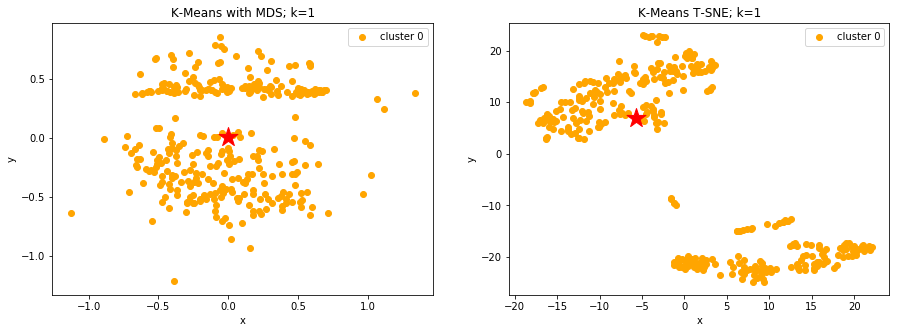

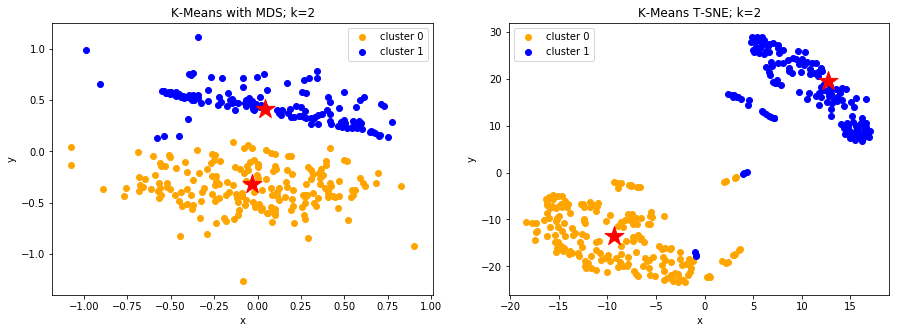

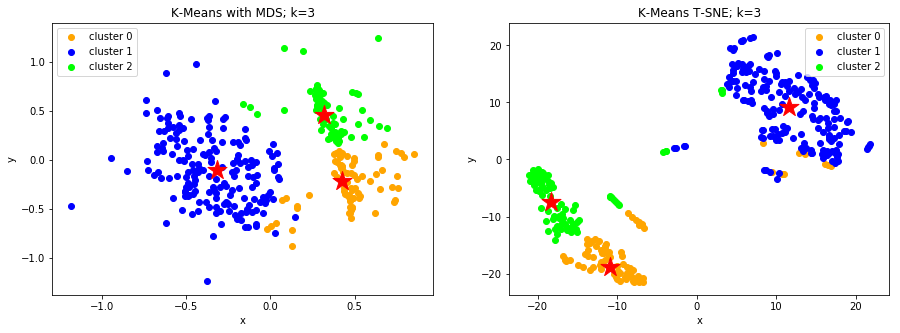

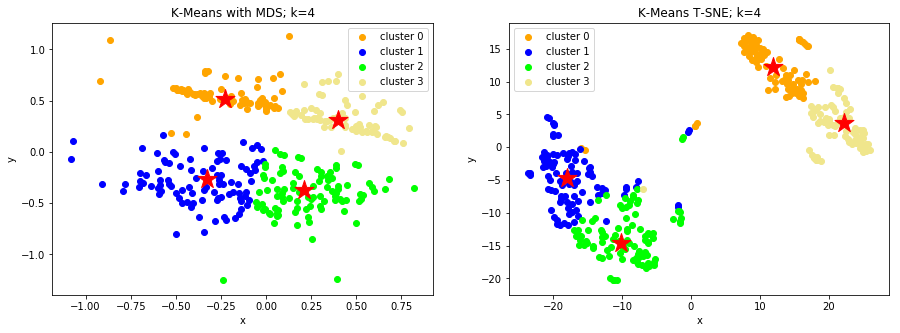

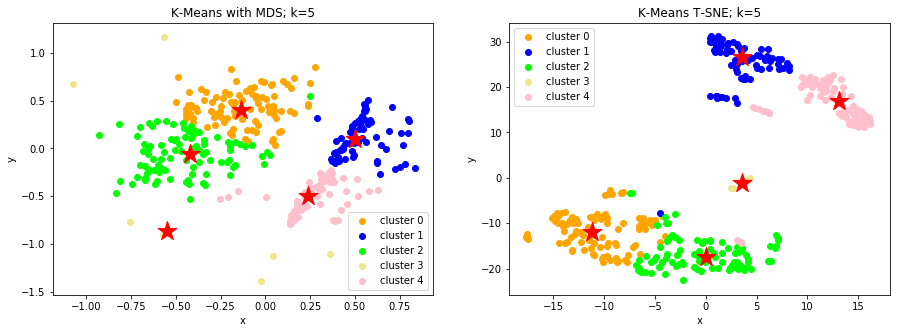

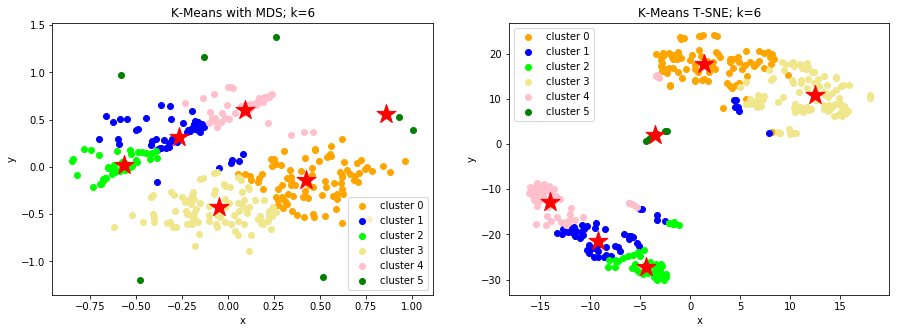

In [15]:
output = dict()

# Call the K-means clustering function
for n in range(min_num_clusters, max_num_clusters):
    output[n] = kmeans_clustering(quantile_uniform_data, n)
    plt.show()

### Cluster Analysis

The visual inspection of the plots suggest that the most probable number of clusters is 4

In [16]:
# Create a copy of dataframe
df_kmeans = df.copy()

# Add the cluster labels of k=4 as an extra column in the original loan dataframe
df_kmeans['cluster'] = pd.Series(output[4][0].labels_, index=df.index)

In [17]:
df_kmeans.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,cluster
0,2483,2466.0,90,180,0,2
1,4917,0.0,130,360,0,0
2,4106,0.0,40,180,1,3
3,3859,3300.0,142,180,1,1
4,6417,0.0,157,180,1,0


In [18]:
df_kmeans.mean()

ApplicantIncome      5201.093373
CoapplicantIncome    1495.508795
LoanAmount            140.882530
Loan_Amount_Term      341.710843
Credit_History          0.978916
cluster                 1.475904
dtype: float64

In [19]:
# Compute the mean value of each attribute for each cluster
df_kmeans.groupby('cluster').mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
cluster,,,,,
0,9338.506667,16.720000,198.493333,336.800000,0.960000
1,5096.419355,3085.333333,176.150538,343.225806,0.978495
2,2640.200000,2181.967579,103.694737,347.242105,0.978947
3,4370.855072,14.956522,81.927536,337.391304,1.000000


### Observation from the clusters using K-means:

| Cluster number | description   |
|----------------|---------------|
|Cluster 0 | Customers with **very high Applicant Income** group with a **very high loan amount** with low Co-applicant Income|
|Cluster 1 | Customers with average Applicant Income group and **very high Co-applicant Income** with above average loan amount |
|Cluster 2 | Customers with **very low Applicant Income** and above average Co-applicant Income|
|Cluster 3 | Customers with below average Applicant Income and **very low Co-applicant Income** with **very low Loan Amount** and a **Credit History of 1**|



# Task 2 (CS5062)
*Plot the sum of squared distances from the data points (in loans_dataset_et3.csv) to the centers of the k-Means clusters for various values of k. Use the Elbow method to pick the best value of k. Attempt also another method for determining the best value of k. If these methods suggest a different value of k (from the one you used in Task 1), then compute a new k-Means clustering.*

*Use another clustering algorithm (from the ones available in scikit-learn) for the same dataset and an appropriate manifold-learning technique to visualise it.*

*Discuss the differences between the k-Means clustering and the clustering found by the second algorithm you have tried in words (max 250 words) and by visualising the clustering’s with an appropriate manifold-learning technique.*

## Plotting the Sum of Squared distances and applying Elbow method

SSE for 1 cluster = 117.93565366310898
SSE for 2 cluster = 70.78355526826287
SSE for 3 cluster = 54.512640531014995
SSE for 4 cluster = 40.44126607418319
SSE for 5 cluster = 35.137093923613115
SSE for 6 cluster = 31.04218934834786
SSE for 7 cluster = 28.02647710231204
SSE for 8 cluster = 25.244839279946724
SSE for 9 cluster = 23.057725126307222
SSE for 10 cluster = 21.765492180429746
SSE for 11 cluster = 20.019258184016927
SSE for 12 cluster = 18.502588173669555
SSE for 13 cluster = 17.49460196168556
SSE for 14 cluster = 16.11280021037343


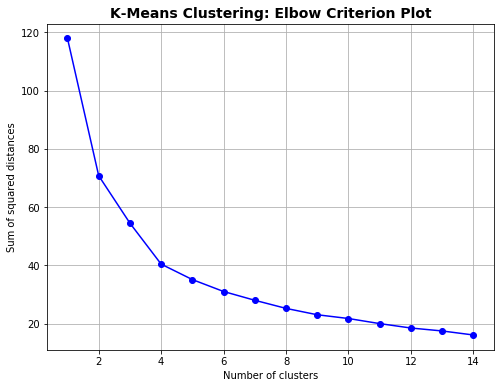

In [20]:
SSE = []

# Create a range of clusters 
num_clusters = range(1,15)

# For loop to run K-means for each cluster vakue 'k' and find the SSE
for k in num_clusters:
    km = cluster.KMeans(n_clusters=k, n_init=10, max_iter=500).fit(quantile_uniform_data)
    SSE.append(km.inertia_)
    print("SSE for {} cluster = {}".format(k, km.inertia_))

plt.figure(figsize=(8,6))
plt.plot(num_clusters, SSE, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title("K-Means Clustering: Elbow Criterion Plot", fontsize=14, fontweight='bold')
plt.grid()
plt.show()

### Observation on Elbow plot:
Usually an 'elbow' is apparent where the reduction in sum of square errors(SSE) levels off as the number of clusters increses. This indicates that increasing the number of clusters does not improve the clustering.

**The elbow can be seen at the optimal number of clusters, k = 4** where the **SSE is not reducing drastically(slope is less)** and even if we add more clusters the SSE decay is very slow and not adding any significance to the clustering process

## Attempt another method for determining the best value of k and an appropriate manifold-learning technique to visualise it. 

Reference for clustering algorithms: https://scikit-learn.org/stable/modules/clustering.html

### Clustering Algorithm Selected: Affinity Propagation

Hyper-parameters:
- preference
    - can be used to control how many data points are selected as exemplars
- damping
    - damping factor dampfact should be at least 0.5 and less than 1
    - Higher damping factors will lead to slower convergence

### Manifold techniques used for Affinity Propagation:
1. Isomap
2. T-SNE

##### References:    
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html
- https://www.psi.toronto.edu/affinitypropagation/faq.html    
- An attempt to use other techniques besides MDS and t-SNE. (https://www.youtube.com/watch?v=j8080l9Pvic)

In [21]:
def affinity_propagation(data, preference):
    # Function to do the clustering using Affinity Propagation  
    
    # Affinity Propagation on various 'preference' values
    af_clustering = cluster.AffinityPropagation(damping=0.9, 
                                                max_iter=500, 
                                                convergence_iter=50,  
                                                preference=preference, 
                                                verbose=True).fit(data)

    af_cluster_centers = af_clustering.cluster_centers_

    # get the number of clusters
    af_clusters = len(af_clustering.cluster_centers_indices_)

    # Append the cluster centers to the dataset
    af_data_and_centers = np.r_[data, af_cluster_centers]
 
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    
    # Trying Isomap manifold technique
    XYcoordinates = manifold.Isomap(n_neighbors=5, n_components=2).fit_transform(af_data_and_centers)

    # plot the transformed examples and the centers
    clustering_scatterplot(points=XYcoordinates[:-af_clusters,:], 
                           labels=af_clustering.labels_, 
                           centers=XYcoordinates[-af_clusters:,:], 
                           title='Isomap for Affinity Propagation; preference {}; clusters={}'.format(
                               preference, af_clusters))
    
         
    plt.subplot(1, 2, 2)
    # Apply the t-SNE transformation to project both the data and the k-Means cluster centers to a 2D space
    XY_tsne_coordinates = manifold.TSNE(n_components=2, 
                                        perplexity=30, 
                                        learning_rate=200).fit_transform(af_data_and_centers)
    # Plot the t-SNE clusters
    clustering_scatterplot(points=XY_tsne_coordinates[:-af_clusters,:], 
                           labels=af_clustering.labels_, 
                           centers=XY_tsne_coordinates[-af_clusters:,:], 
                           title='T-SNE for Affinity Propagation; preference {}; clusters={}'.format(
                               preference, af_clusters))
    plt.show()
    return af_clustering, af_clusters

Converged after 76 iterations.


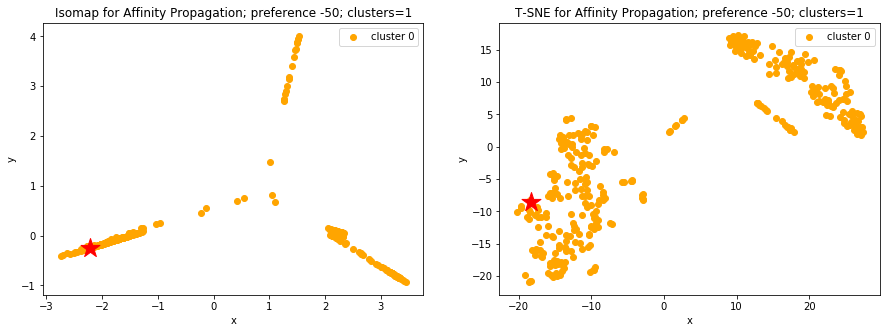

Converged after 81 iterations.


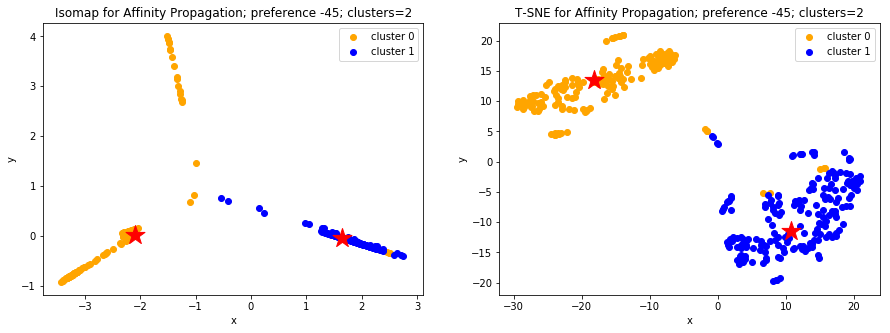

Converged after 78 iterations.


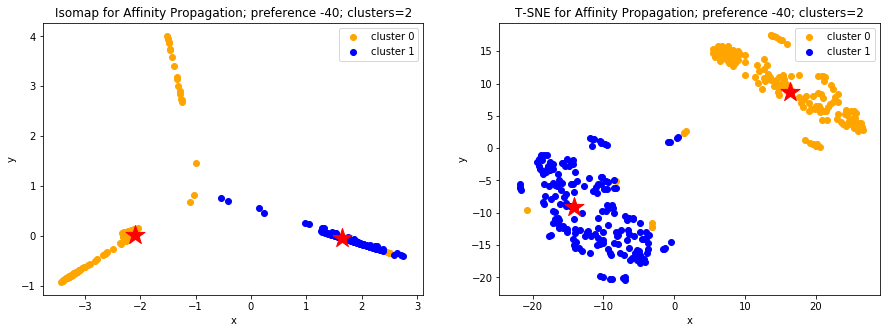

Converged after 76 iterations.


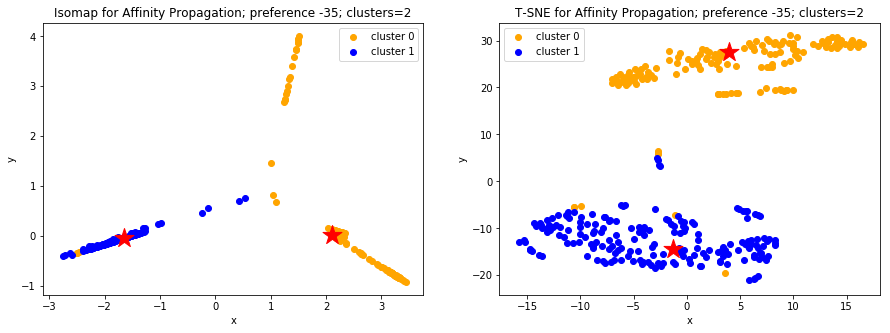

Converged after 77 iterations.


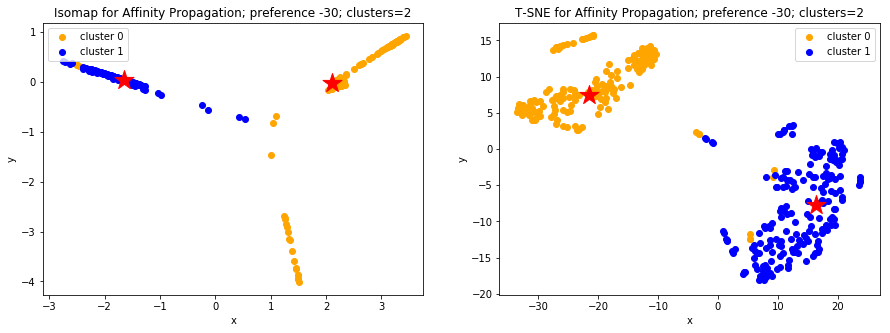

Converged after 80 iterations.


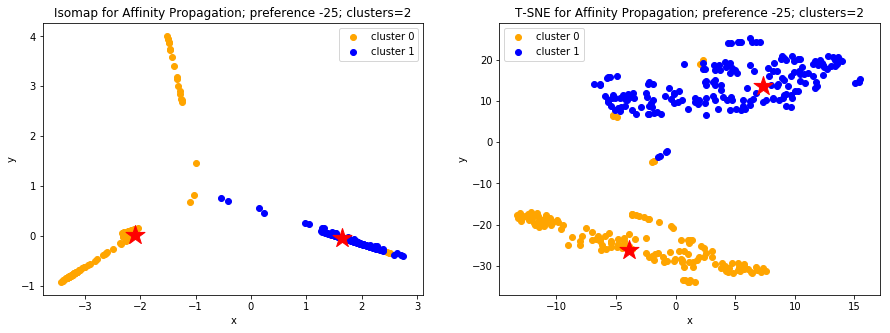

Converged after 82 iterations.


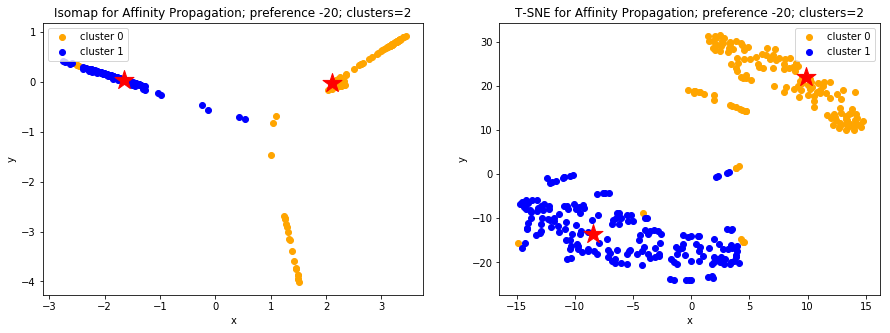

Converged after 91 iterations.


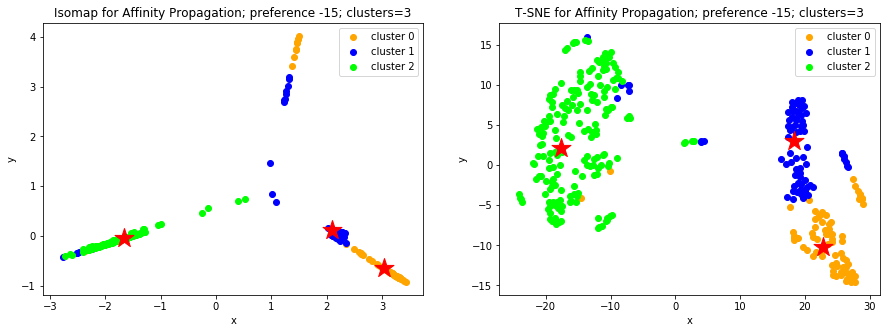

Converged after 79 iterations.


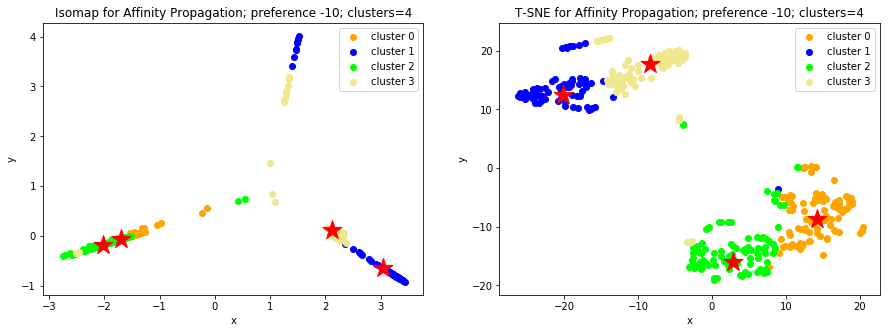

Converged after 107 iterations.


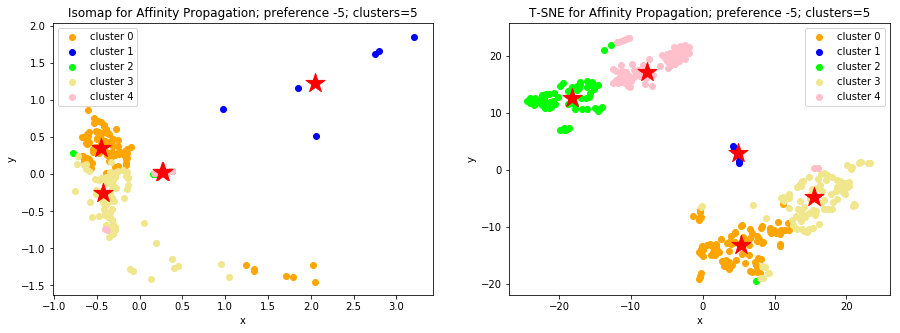

In [22]:
# Store the scaled data in X_scaled
X_scaled = quantile_uniform_data

# Hyperparameter choice for preference
max_preference = 0
min_preference = -50

# Jump 5 steps per preference value
preference_range = range(min_preference, max_preference, 5)

result = dict()
num_clusters=[]
for pref in preference_range:
    result[pref], af_cluster = affinity_propagation(X_scaled, pref)
    num_clusters.append(af_cluster)

In [23]:
# Store the preference and cluster number from Affinity propagation 
clusters_df = pd.DataFrame( {'preference_range': preference_range, 'num_clusters':num_clusters} )
clusters_df

,preference_range,num_clusters
0,-50,1
1,-45,2
2,-40,2
3,-35,2
4,-30,2
5,-25,2
6,-20,2
7,-15,3
8,-10,4
9,-5,5


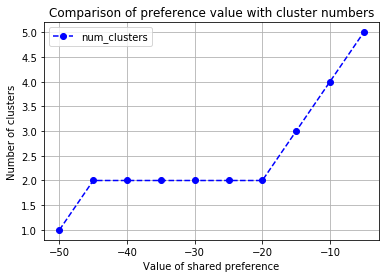

In [24]:
# Plot the effect on parameter "preference" and "cluster number" for Affinity propagation clsutering

plt.plot(clusters_df.preference_range, clusters_df.num_clusters, 'bo--')
plt.title('Comparison of preference value with cluster numbers')
plt.ylabel('Number of clusters')
plt.xlabel('Value of shared preference')
plt.grid()
plt.legend()
plt.show()

### Observations from Affinity Propagation clustering technique:

The optimal number of clusters after using the Affinity Propagation clustering algorithm using various `preference` values is seen to be 2. The visual inspection using T-SNE manifold technique however shows that 4 clusters are more appropriate.

The value of `preference` plays a very important role in picking up the number of clusters in the Affinity Propagation clustering technique. **For preference values -20 to -45 we can see that the number of clusters found are always 2**. For other values of preference the number of clusters are not stable and change very quickly. Even with 0 preference value we will have a lot of clusters(almost all data points are clusters in that case). 

General observation was:
- low preferences leading to small numbers of clusters 
- high preferences leading to large numbers of clusters

| `preference` value | num_clusters  |
|----------------|-------------------|
|-50|1|
|-45 to -20|2|
|-15|3|
|-10|4|
|-5|5|

### Cluster Analysis: Affinity Propagation clustering technique

In [25]:
# Create a copy of dataframe
df_afprop = df.copy()

# Using perplexity of -10 in Affninity propagation results which gives 4 clusters
df_afprop['cluster'] = pd.Series(result[-10].labels_, index=df.index)

df_afprop.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,cluster
0,2483,2466.0,90,180,0,0
1,4917,0.0,130,360,0,3
2,4106,0.0,40,180,1,1
3,3859,3300.0,142,180,1,2
4,6417,0.0,157,180,1,3


In [26]:
df_afprop.mean()

ApplicantIncome      5201.093373
CoapplicantIncome    1495.508795
LoanAmount            140.882530
Loan_Amount_Term      341.710843
Credit_History          0.978916
cluster                 1.454819
dtype: float64

In [27]:
# K-Means cluster for comparision with Affinity Propagation
df_kmeans.groupby('cluster').mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
cluster,,,,,
0,9338.506667,16.720000,198.493333,336.800000,0.960000
1,5096.419355,3085.333333,176.150538,343.225806,0.978495
2,2640.200000,2181.967579,103.694737,347.242105,0.978947
3,4370.855072,14.956522,81.927536,337.391304,1.000000


In [28]:
# Affinity Propagation clusters
df_afprop.groupby('cluster').mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
cluster,,,,,
0,2583.336957,2205.825217,103.315217,346.826087,0.978261
1,4454.112676,14.535211,82.957746,338.028169,1.000000
2,5007.389474,3054.326316,173.715789,343.578947,0.978947
3,9420.972973,32.162162,201.013514,336.486486,0.959459


### Observation from the clusters using Affinity Propagation:
The results of Affinity propagation clusters are very similar to the K-Means clustering results for 4 clusters.

| Cluster number | Cluster Description   |
|----------------|---------------|
|Cluster 0 | Customers with **very low Applicant Income** and above average Co-applicant Income|
|Cluster 1 | Customers with below average Applicant Income and **very low Co-applicant Income** with **very low Loan Amount** and a **Credit History of 1**|
|Cluster 2 | Customers with average Applicant Income group and **very high Co-applicant Income** with above average loan amount |
|Cluster 3 | Customers with **very high Applicant Income** group with a **very high loan amount** with low Co-applicant Income|


### Differences between the k-Means clustering and the clustering found by Affinity Propagation algorithm
K-means algorithms clusters the data into n clusters of equal variance minimizing the within-cluster Euclidean distance. 
- The algorithm requires the samples and the number of clusters as input
- k-means assumes that clusters are convex shaped and forms cluster of even size

Affinity Propagation algorithm forms clusters by sending messages between pairs of instances until convergence
- The algorithm choses the clusters based on the data
- Affinity propagation finds "exemplars", members of the input set that are representative of clusters where `damping` damps the responsibility and availability messages, `preference` controls the number of exemplars 
- It forms many clusters of uneven size

### Silhouette score analysis to understand the optimal number of clusters

The silhouette analysis measures how well an observation is clustered and it *estimates the average distance between clusters*. 

The silhouette_score gives the average value for all the samples. Silhouette coefficients range between -1 and 1, with 1 indicating dense, well separated clusters. This gives a perspective into the density and separation of the formed clusters

Reference: 
1. https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
2. https://chrisalbon.com/machine_learning/clustering/evaluating_clustering/
3. https://www.datanovia.com/en/lessons/cluster-validation-statistics-must-know-methods/#silhouette-coefficient

In [29]:
from sklearn.metrics import silhouette_score

# Loop to find the silhouette score for k=2 to k=10 number of clusters
for k in range(2, 11):
    
    # Apply K-Means clustering on the scaled data
    kmeans = cluster.KMeans(n_clusters=k, n_init=10, max_iter=500).fit(X_scaled)
    
    # Get the labels
    label = kmeans.labels_
   
    # Calculate the silhoutte score
    sil_coeff = silhouette_score(X_scaled, label, metric='euclidean')
    
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(k, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.3958331519475405
For n_clusters=3, The Silhouette Coefficient is 0.3717353085258766
For n_clusters=4, The Silhouette Coefficient is 0.3685989117677958
For n_clusters=5, The Silhouette Coefficient is 0.3828607398313568
For n_clusters=6, The Silhouette Coefficient is 0.34162019857901854
For n_clusters=7, The Silhouette Coefficient is 0.36408926084722965
For n_clusters=8, The Silhouette Coefficient is 0.33267424065672535
For n_clusters=9, The Silhouette Coefficient is 0.3411891279954565
For n_clusters=10, The Silhouette Coefficient is 0.35690598569914117


The maximum score for silhouette is for cluster number 2 and cluster number 5

###  Lets visualize the Silhouette
The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters.

Reference: http://www.awesomestats.in/python-cluster-validation/

For n_clusters = 2 The average silhouette_score is : 0.3958331519475405


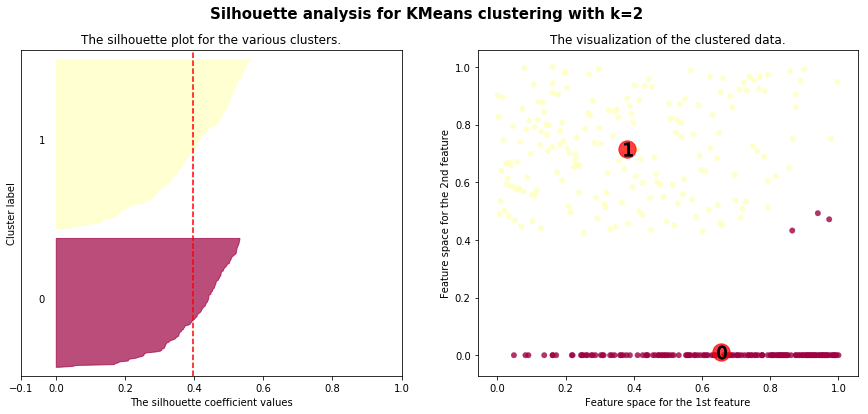

For n_clusters = 3 The average silhouette_score is : 0.36124416254672037


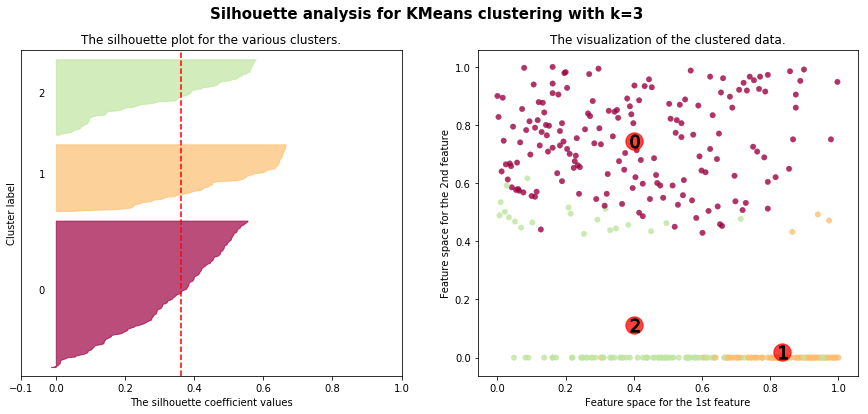

For n_clusters = 4 The average silhouette_score is : 0.3685989117677958


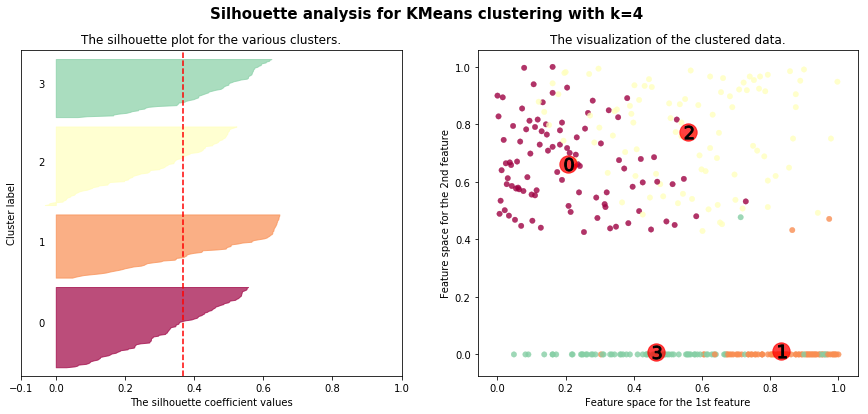

For n_clusters = 5 The average silhouette_score is : 0.3832755211182266


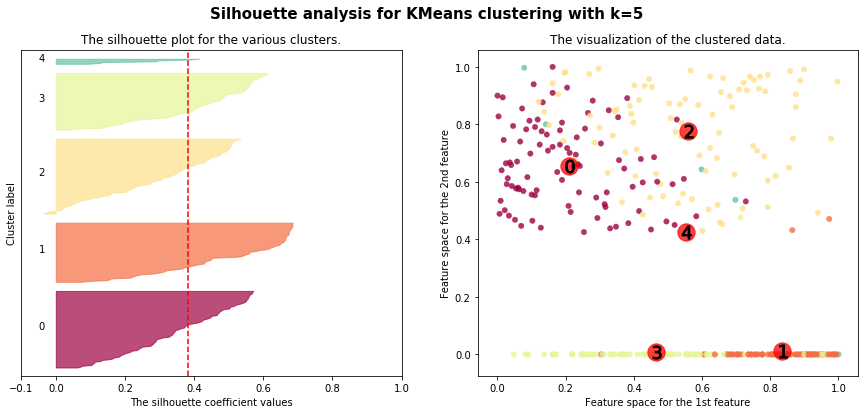

For n_clusters = 6 The average silhouette_score is : 0.3514178223370438


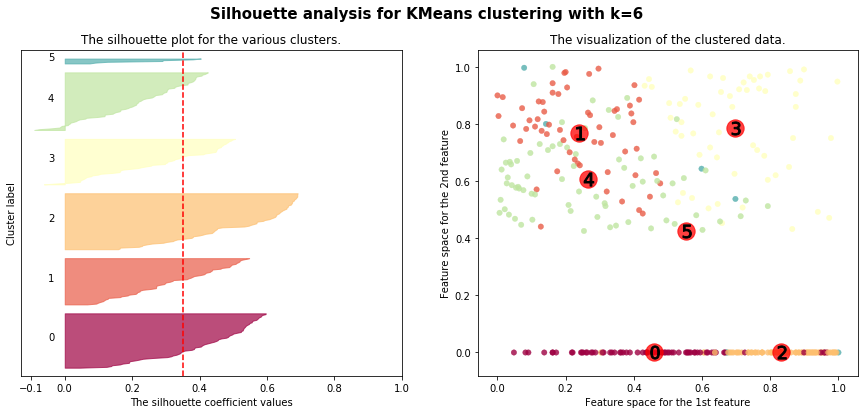

In [30]:
from sklearn.metrics import silhouette_samples

cluster_range = range(2, 7)

# Loop to find the silhouette score for k=2 to k=6 number of clusters
for n_clusters in cluster_range:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 6)

    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, 
    # to demarcate them clearly.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value
    clusterer = cluster.KMeans(n_clusters=n_clusters, n_init=10, max_iter=500)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # Calulate the average silhouette score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    # Clear the yaxis labels / ticks
    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.Spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='o', s=30, lw=0.35, alpha=0.8, c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw red circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="red", alpha=0.75, s=300)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], color='black', marker='$%d$' % i, alpha=1, s=175)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering with k={}".format(n_clusters)),
                 fontsize=15, fontweight='bold')

    plt.show()

### Observation on Silhouette score visualization:
The above plots suggests that the maximum Silhouette score is for K-Means with 2 and 5 clusters. Also there are observations with a negative score (for K-Means with k>2) and hence probably some samples are placed in the wrong cluster for higher number of clusters.

The visual inspection is a bit subjective here but we can see that **2 clusters are more appropriate as the cluster sizes are fairly homogeneous with high Silhouette score and non-negative coefficient values**.